# Task 2 : Building the baseline model

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import itertools
import math

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, test_data_Pipeline_non_normalized
from funcs_Task2_3 import plot_accuracy_loss, concat_generators, plot_confusion_matrix

2025-05-02 08:25:55.604487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 08:25:55.604569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 08:25:55.605876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs = 30

### 1. Set up the classification

In [3]:
# Set random seeds for reproducibility
np.random.seed(123)  
tf.random.set_seed(123) 
tf.keras.utils.set_random_seed(123)

# evaluation metrics
METRICS = ["accuracy"]

### 2. Build initial model


In [4]:
model = models.Sequential()

# Convolutional Part
model.add(layers.Input(shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))  
model.add(layers.MaxPooling2D(2, 2))                     
model.add(layers.BatchNormalization())                 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))                         

# Fully Connected Part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))          
model.add(layers.Dropout(0.5))                                

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))             

# Compile model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

2025-05-02 08:26:30.990788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


### 3. Train your model

In [5]:
# Use existing data pipelines
train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir=val_dir, train_dir=train_dir)

# Get sample counts (if not already defined)
total_train = train_data_gen.samples
total_val = val_data_gen.samples

# Compile the model (keep your existing METRICS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
   metrics=METRICS
)

# Train the model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
)


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/30


2025-05-02 08:26:38.398592: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-02 08:26:41.874669: I external/local_xla/xla/service/service.cc:168] XLA service 0x150be1b544a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-02 08:26:41.874711: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-05-02 08:26:41.881277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746167201.990445  230502 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 14s 448ms/step - loss: 4.0836 - accuracy: 0.5700 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 2/30
13/13 [==============================] - 6s 454ms/step - loss: 0.6051 - accuracy: 0.6162 - val_loss: 0.6863 - val_accuracy: 0.5100
Epoch 3/30
13/13 [==============================] - 6s 454ms/step - loss: 0.5683 - accuracy: 0.6994 - val_loss: 0.6768 - val_accuracy: 0.5275
Epoch 4/30
13/13 [==============================] - 6s 456ms/step - loss: 0.5221 - accuracy: 0.7194 - val_loss: 0.6620 - val_accuracy: 0.5925
Epoch 5/30
13/13 [==============================] - 6s 456ms/step - loss: 0.5371 - accuracy: 0.7375 - val_loss: 0.6586 - val_accuracy: 0.6050
Epoch 6/30
13/13 [==============================] - 6s 456ms/step - loss: 0.5181 - accuracy: 0.7469 - val_loss: 0.6606 - val_accuracy: 0.6425
Epoch 7/30
13/13 [==============================] - 6s 455ms/step - loss: 0.5124 - accuracy: 0.7319 - val_loss: 0.6364 - val_accuracy: 0.6400
Epoch 8/30
13/13

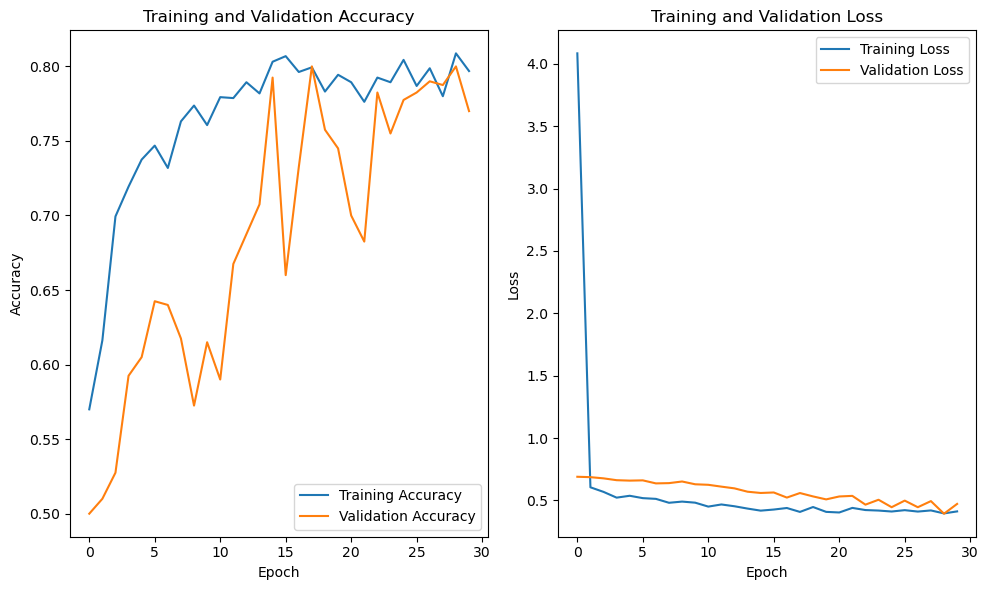

In [ ]:
plot_accuracy_loss(history, epochs)

### 4. Hyperparameter tuning

In [7]:
# implementing early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [8]:
def build_base_model(filter, dropout_rate, optimizer_choice, learning_rate, metrics):

    model = models.Sequential()

    # Convolutional Part
    model.add(layers.Input(shape=(128, 128, 3)))
    model.add(layers.Conv2D(filter, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filter, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))

    # Fully Connected Part
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile with chosen optimizer and learning rate
    if optimizer_choice == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics = metrics)

    return model

In [9]:
# Loop over different combinations of hyperparameters to do grid search

# specify different values of hyperparameters to tune
filters = [8, 32, 64]
dropout_rate = [0.4, 0.3, 0.2]
learning_rate = [1e-3, 1e-4, 1e-5]
optimizer_choice = ['adam', 'sgd']


results = []

for comb in itertools.product(filters, dropout_rate, learning_rate, optimizer_choice):
    filter = comb[0]
    dropout_rate = comb[1]
    learning_rate = comb[2]
    optimizer_choice = comb[3]
    print(f'start model with filter: {filter}, dropout rate: {dropout_rate}, learning rate: {learning_rate}, optimizer: {optimizer_choice}')

    # build model en fit model
    model = build_base_model(filter, dropout_rate, optimizer_choice, learning_rate, METRICS)

    history = model.fit(
         train_data_gen,
         batch_size = batch_size, 
         epochs = epochs,
         validation_data = val_data_gen, 
         callbacks = [early_stop],
         verbose = 0
    )

    # Collect results
    best_val_acc = max(history.history['val_accuracy'])
    amount_epochs = max(history.epoch)
    results.append({
        'filter': filter,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer_choice,
        'val_accuracy': best_val_acc,
        'epochs': amount_epochs
    })

    print(f"Done with filter: {filter}, dropout rate: {dropout_rate}, learning rate: {learning_rate}, optimizer: {optimizer_choice}, val_acc={best_val_acc:.4f}, epochs = {amount_epochs}")


df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task2_grid.csv", index=False)


start model with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: adam
Done with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: adam, val_acc=0.5000, epochs = 3
start model with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: sgd
Done with filter: 8, dropout rate: 0.4, learning rate: 0.001, optimizer: sgd, val_acc=0.7275, epochs = 29
start model with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: adam
Done with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: adam, val_acc=0.8325, epochs = 29
start model with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: sgd
Done with filter: 8, dropout rate: 0.4, learning rate: 0.0001, optimizer: sgd, val_acc=0.6875, epochs = 29
start model with filter: 8, dropout rate: 0.4, learning rate: 1e-05, optimizer: adam
Done with filter: 8, dropout rate: 0.4, learning rate: 1e-05, optimizer: adam, val_acc=0.7275, epochs = 29
start model with filter: 8, dropout rate:

### 5. final baseline

In [11]:
# get data generators and specify hyperparameters (best performing from tuning)
training_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

total_train = train_data_gen.samples + val_data_gen.samples

best_run = df[df.val_accuracy == df.val_accuracy.max()]
learning_rate = best_run.learning_rate.iloc[0]
dropout_rate = best_run.dropout_rate.iloc[0]
filters = best_run['filter'].iloc[0]
optimizer = best_run.optimizer.iloc[0]
epochs = best_run.epochs.iloc[0]
best_val_acc = best_run.val_accuracy.iloc[0]

print(f"Best performing hyperparameters: filters = {filter}, dropout rate = {dropout_rate}, learning rate = {learning_rate}, optimizer = {optimizer}, epochs ran = {amount_epochs}, val_acc={best_val_acc:.4f}")

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Best performing hyperparameters: filters = 64, dropout rate = 0.2, learning rate = 0.0001, optimizer = adam, epochs ran = 29, val_acc=0.9050


In [12]:
## fit final baseline model
final_baseline_model = build_base_model(filter, dropout_rate, optimizer_choice, learning_rate, METRICS)

history = final_baseline_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch= math.ceil(total_train / batch_size),
    epochs=epochs
)

Epoch 1/29
16/16 [==============================] - 7s 412ms/step - loss: 0.6985 - accuracy: 0.5832
Epoch 2/29
16/16 [==============================] - 7s 429ms/step - loss: 0.6217 - accuracy: 0.6729
Epoch 3/29
16/16 [==============================] - 7s 428ms/step - loss: 0.5903 - accuracy: 0.7072
Epoch 4/29
16/16 [==============================] - 7s 428ms/step - loss: 0.5563 - accuracy: 0.7298
Epoch 5/29
16/16 [==============================] - 7s 426ms/step - loss: 0.5404 - accuracy: 0.7375
Epoch 6/29
16/16 [==============================] - 7s 427ms/step - loss: 0.5286 - accuracy: 0.7450
Epoch 7/29
16/16 [==============================] - 7s 429ms/step - loss: 0.5329 - accuracy: 0.7460
Epoch 8/29
16/16 [==============================] - 7s 427ms/step - loss: 0.5222 - accuracy: 0.7470
Epoch 9/29
16/16 [==============================] - 7s 426ms/step - loss: 0.5043 - accuracy: 0.7651
Epoch 10/29
16/16 [==============================] - 8s 513ms/step - loss: 0.5104 - accuracy: 0.7535

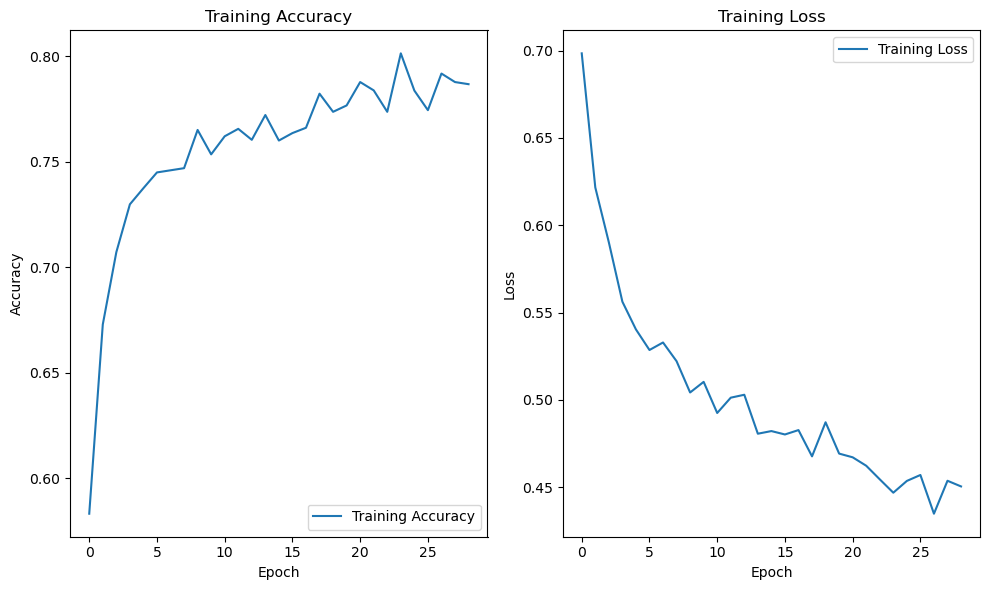

In [13]:
plot_accuracy_loss(history, epochs, validation = False)

In [14]:
# Save the model to disk and load it back
final_baseline_model.save('covid_xray_baseline_model.keras')  # Save the model
loaded_model = tf.keras.models.load_model('covid_xray_baseline_model.keras')  # Load the model

# model evaluation, print performance metrics
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir)
loss, accuracy = loaded_model.evaluate(test_data_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
2/2 [==============================] - 2s 2s/step - loss: 0.5424 - accuracy: 0.7200
Test Loss: 0.5424
Test Accuracy: 0.7200


2/2 [==============================] - 1s 1s/step


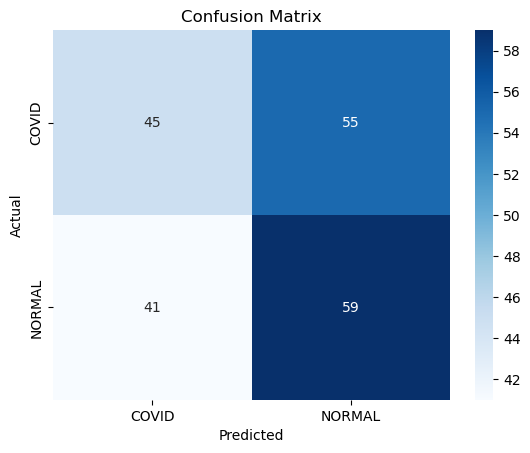

In [15]:
# confusion matrix
y_true = test_data_gen.classes
y_pred_probs = final_baseline_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

plot_confusion_matrix(y_true, y_pred, test_data_gen)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
2/2 [==============================] - 0s 126ms/step
Found 200 images belonging to 2 classes.


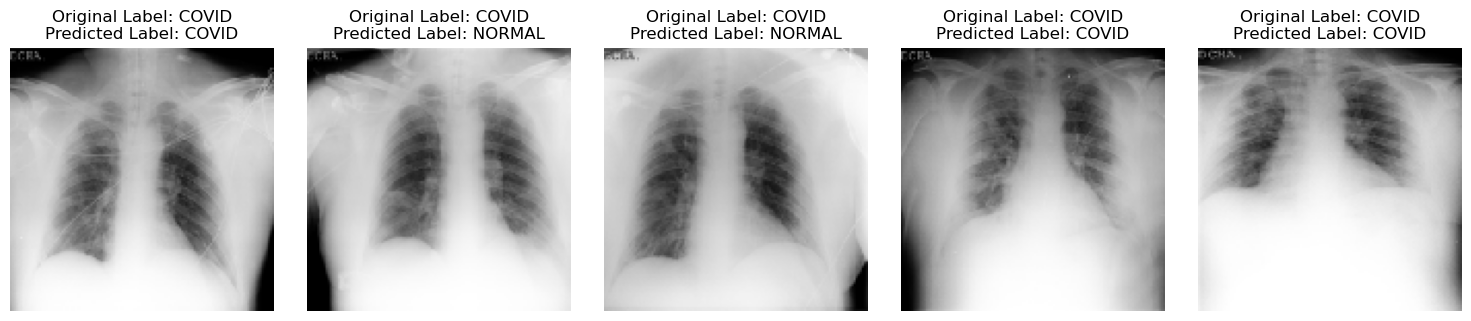

In [16]:
# Plot a few samples from the test dataset without normalization with evaluation (after normalization)
#TODO: check if images can be randoms
def get_images_pred_vs_true_label(batch_size, img_size, train_dir, test_dir, model):
# Get batch and process
    ## normalized 
    test_data_gen_normalized  = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
    y_pred_probs = model.predict(test_data_gen_normalized)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    ## non-normalized 
    test_data_gen_non_normalized = test_data_Pipeline_non_normalized(batch_size, img_size, test_dir)
    sample_images_non_normalized, sample_labels_non_normalized =  next(test_data_gen_non_normalized)

    ## show figures with labels
    class_names = list(test_data_gen_normalized.class_indices.keys())

    plt.figure(figsize=(15, 6))
    for i, (img, label, pred) in enumerate(zip(sample_images_non_normalized[:5], sample_labels_non_normalized[:5], y_pred[:5])):
        plt.subplot(2, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original Label: {class_names[int(label)]}\nPredicted Label: {class_names[pred]}"), plt.axis('off')
        
    plt.tight_layout()
    plt.show()

get_images_pred_vs_true_label(batch_size, img_size, train_dir, test_dir, final_baseline_model)